<a href="https://colab.research.google.com/github/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/blob/main/THOMAS_MVP_SPRINT_3_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MVP Machine Learning & Analytics**<br>
<hr>
Versão: 1.0

**Nome:** Thomas Alves de Souza Abrantes  
**Matrícula:** 4052025000680 (RA)

**Dataset:** Datasets extraídos do Portal "Dados Abertos" do Governo Federal.  

*  **Fonte dos dados:** https://dados.gov.br/dados/conjuntos-dados/ocorrencias-aeronauticas-da-aviacao-civil-brasileira
*  O link abre os arquivos disponibilizados pelo CENIPA, contendo informações das ocorrências aeronáuticas na aviação Civil Brasileira, separados em 5 arquivos:
    *  Aeronaves
    *  Dados da ocorrência
    *  Tipo de ocorrência
    *  Fator contribuinte
    *  Recomendações
  
Os dados em cada arquivo serão analisados com mais detalhes após a carga.  
A imagem abaixo ilustra o modelo de dados dos arquivos (datasets).

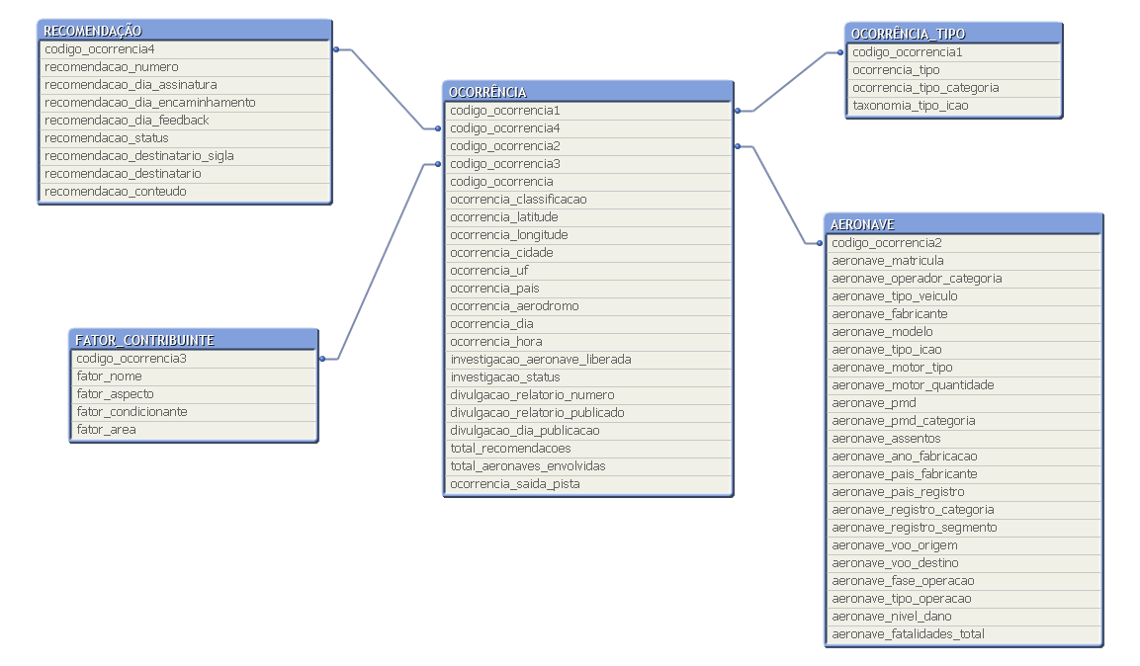

#**Introdução e Objetivos**

O objetivo principal deste projeto é criar um modelo preditivo robusto para classificar a gravidade de ocorrências aeronáuticas no Brasil em três categorias:
*  Acidente
*  Incidente Grave
*  Incidente

Uma classificação precisa é vital para a segurança operacional e para a eficiente alocação de recursos de investigação.

Com base nos dados do CENIPA, o modelo utiliza características detalhadas da aeronave e da ocorrência. As variáveis incluem o Nível de Dano (que se provou o fator de maior peso na classificação), o tipo de falha, o ano de fabricação e a capacidade de passageiros.

O objetivo é desenvolver uma ferramenta capaz de diferenciar as três classes de forma consistente e com alta confiabilidade, fornecendo uma valiosa análise preditiva para o sistema de segurança aeronáutica.

#**Observação**

A seção **Comparando os modelos XGBoost, LightGBM e Random Forest** é a etapa de maior consumo de tempo, com uma execução de aproximadamente 10 minutos e **deixei o código comentado** pois em alguns casos esta dando erro de **falta de memória RAM**.  

Para otimizar o fluxo de trabalho e focar na conclusão, deixei uma cópia do **RESULTADO** (F1-Score, Acurácia e Tempo de Treino) de cada modelo. Esta comparação direta é essencial para justificar tecnicamente a escolha do algoritmo final.  

**Todos os modelos treinados estão salvos**, e o código para salvar, realizar o download e carregar o modelo treinado está comentado no notebook, caso seja necessário reralizar algumas destas etapas.

#**Configuração do notebook**

##Bibliotecas

Instalações necessárias:
*  **XGBoost:** Biblioteca de código aberto e um algoritmo de machine learning que implementa a técnica de gradient boosting para resolver problemas de regressão e classificação, especialmente em dados tabulares.
*  **imbalanced-learn:** Biblioteca Python de código aberto projetada para ajudar a resolver problemas de desequilíbrio de classes em aprendizado de máquina. A biblioteca fornece ferramentas e algoritmos para processar conjuntos de dados desbalanceados e melhorar o desempenho do modelo.

In [ ]:
!pip install xgboost
!pip install imbalanced-learn

Importações

In [ ]:
# Bibliotecas do notebook
import joblib
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
import joblib
import requests
import time
import lightgbm as lgbm
import gc

# Omite warning de deprecated no pandas
warnings.filterwarnings('ignore', category=DeprecationWarning, module='pandas')

from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
from google.colab import files
from io import BytesIO
from sklearn.metrics import f1_score, accuracy_score
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

##Variáveis globais

In [ ]:
# URLs dos arquivos raw no repositório do GitHub
URL_AERONAVES = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/aeronave.csv'
URL_OCORRENCIA = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/ocorrencia.csv'
URL_OCORRENCIA_TIPO = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/ocorrencia_tipo.csv'
URL_FATOR_CONTRIBUINTE = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/fator_contribuinte.csv'
URL_RECOMENDACAO = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/recomendacao.csv'

#Mensagens
MSG_DATAFRAME_LIMPO_SUFIX = 'sem valores Nulos'
MSG_LISTA_VALORES_COLUNA = 'Lista de todos os valores da coluna'
MSG_A_PREVISAO_DO_MODELO_E = 'A previsão para o novo dado é:'
MSG_TOTAL_REGISTROS = 'Total de registros'
MSG_TOTAL_COLUNAS = 'Total de colunas'
MSG_DADOS_NULOS_POR_COLUNA = 'Dados de Nulos por Coluna'

#Dataframes
DATAFRAME_CONSOLIDADO = 'Dataframe Consolidado'
DATAFRAME_AERONAVES = 'Dataframe Aeronaves'
DATAFRAME_OCORRENCIAS = 'Dataframe Ocorrências'
DATAFRAME_TIPO_OCORRENCIA = 'Dataframe Tipo de Ocorrência'
DATAFRAME_FATOR_CONTRIBUINTE = 'Dataframe Fator Contribuinte'
DATAFRAME_RECOMENDACAO = 'Dataframe Recomendação'
DATAFRAME_AERONAVES_SEM_NULOS = DATAFRAME_AERONAVES + ' ' + MSG_DATAFRAME_LIMPO_SUFIX
DATAFRAME_OCORRENCIAS_SEM_NULOS = DATAFRAME_OCORRENCIAS + ' ' + MSG_DATAFRAME_LIMPO_SUFIX
DATAFRAME_TIPO_OCORRENCIAS_SEM_NULOS = DATAFRAME_TIPO_OCORRENCIA + ' ' + MSG_DATAFRAME_LIMPO_SUFIX
DATAFRAME_RECOMENDACAO_SEM_NULOS = DATAFRAME_RECOMENDACAO + ' ' + MSG_DATAFRAME_LIMPO_SUFIX
DATAFRAME_FATOR_CONTRIBUINTE_SEM_NULOS = DATAFRAME_FATOR_CONTRIBUINTE + ' ' + MSG_DATAFRAME_LIMPO_SUFIX

# Coluna
COLUNA_PERCENTUAL_DE_VALORES_NULOS = 'percentual de valores nulos'

# Outros
ENCODING_LATIN = 'latin1'
SEPARADOS_CSV = ';'
ON_BAD_LINES_SKIP = 'skip'
CARACTERES_PROIBIDOS = r'[\[\]<>,:="\'\s]'
SUBSTITUIR_POR = '_'

##Funções

In [ ]:
#Imprime linhas pontilhadas para separação de mensagens
def separadorLinha(adicionarMaisUmaLinhaVazia = False):
  print("-" * 100)
  if (adicionarMaisUmaLinhaVazia is True):
      print("\n")

def analisar_nulos(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analisa e retorna um DataFrame com a contagem e o percentual
    de valores nulos de cada coluna.

    Args:
        df (pd.DataFrame): O DataFrame a ser analisado.

    Returns:
        pd.DataFrame: Um novo DataFrame com as colunas 'coluna', 'nulos'
                      e 'percentual de valores nulos'.
    """

    # Conta a quantidade de valores nulos em cada coluna
    nulos_por_coluna = df.isnull().sum()

    # Filtra apenas as colunas com valores nulos
    colunas_com_nulos = nulos_por_coluna[nulos_por_coluna > 0]

    # Se não houver colunas com nulos, retorna um DataFrame vazio
    if colunas_com_nulos.empty:
        return pd.DataFrame(columns=['coluna', 'nulos', 'percentual de valores nulos'])

    # Calcula o percentual de nulos
    total_registros = len(df)
    percentual_nulos = (colunas_com_nulos / total_registros) * 100

    # Cria o DataFrame final com os resultados
    df_nulos = pd.DataFrame({
        'coluna': colunas_com_nulos.index,
        'nulos': colunas_com_nulos.values,
        'percentual de valores nulos': percentual_nulos.values
    })

    # Arredonda o percentual para duas casas decimais
    df_nulos['percentual de valores nulos'] = df_nulos['percentual de valores nulos'].round(2)

    return df_nulos


#**Carga dos Dados**

In [ ]:
# Carregando os dataFrames
df_aeronaves = pd.read_csv(URL_AERONAVES, encoding=ENCODING_LATIN, sep=SEPARADOS_CSV, on_bad_lines=ON_BAD_LINES_SKIP)
df_ocorrencias = pd.read_csv(URL_OCORRENCIA, encoding=ENCODING_LATIN, sep=SEPARADOS_CSV, on_bad_lines=ON_BAD_LINES_SKIP)
df_ocorrencia_tipo = pd.read_csv(URL_OCORRENCIA_TIPO, encoding=ENCODING_LATIN, sep=SEPARADOS_CSV, on_bad_lines=ON_BAD_LINES_SKIP)
df_fator_contribuinte = pd.read_csv(URL_FATOR_CONTRIBUINTE, encoding=ENCODING_LATIN, sep=SEPARADOS_CSV, on_bad_lines=ON_BAD_LINES_SKIP)
df_recomendacao = pd.read_csv(URL_RECOMENDACAO, encoding=ENCODING_LATIN, sep=SEPARADOS_CSV, on_bad_lines=ON_BAD_LINES_SKIP)

# Exibindo as primeiras linhas para confirmar o carregamento
print(DATAFRAME_AERONAVES)
separadorLinha()
print(df_aeronaves.head().to_string(index=False))
separadorLinha(True)

print(DATAFRAME_OCORRENCIAS)
separadorLinha()
print(df_ocorrencias.head().to_string(index=False))
separadorLinha(True)

print(DATAFRAME_TIPO_OCORRENCIA)
separadorLinha()
print(df_ocorrencia_tipo.head().to_string(index=False))
separadorLinha(True)

print(DATAFRAME_RECOMENDACAO)
separadorLinha()
print(df_recomendacao.head().to_string(index=False))
separadorLinha(True)

print(DATAFRAME_FATOR_CONTRIBUINTE)
separadorLinha()
print(df_fator_contribuinte.head().to_string(index=False))
separadorLinha(True)

#**Avaliando cada dataframe criado com os dados carregados**

Consulta prévia da estrutura e amostra das primeiras linhas de cada dataframe.

###Dataframe Aeronaves

Estrutura.

In [ ]:
print(DATAFRAME_AERONAVES)
separadorLinha()
df_aeronaves.info()

Listando as primeiras linhas do df_aeronaves.


In [ ]:
df_aeronaves.head()

###Dataframe Ocorrências

Estrutura.

In [ ]:
print(DATAFRAME_OCORRENCIAS)
separadorLinha()
df_ocorrencias.info()

Listando as primeiras linhas df_ocorrencias.

In [ ]:
df_ocorrencias.head()

###DataFrame Tipo de Ocorrência

Estrutura.

In [ ]:
print(DATAFRAME_TIPO_OCORRENCIA)
separadorLinha()
df_ocorrencia_tipo.info()

Listando as primeiras linhas df_ocorrencia_tipo.

In [ ]:
df_ocorrencia_tipo.head()

##Dataframe Fator Contribuinte

Estrutura.

In [ ]:
print(DATAFRAME_FATOR_CONTRIBUINTE)
separadorLinha()
df_fator_contribuinte.info()

Listando as primeiras linhas df_fator_contribuinte.

In [ ]:
df_fator_contribuinte.head()

##Dataframe Recomendação

Estrutura.

In [ ]:
print(DATAFRAME_RECOMENDACAO)
separadorLinha()
df_recomendacao.info()

Listando as primeiras linhas df_recomendacao.

In [ ]:
df_recomendacao.head()

#**Consultando valores nulos**

##Dataframe Aeronaves

Avaliando a necessidade de remover ou normalizar valores inválidos em cada dataframe.

In [ ]:
df_nulos = analisar_nulos(df_aeronaves)

print(DATAFRAME_AERONAVES)
separadorLinha()
print(MSG_DADOS_NULOS_POR_COLUNA)
separadorLinha()
print(df_nulos)

Em **df_aeronaves** a maior quantidade de valores nulos consta no "numero de assentos", "tipo de motor" e "ano de fabricação".  
Nenhuma informação na documentação informa se a falta de valores no campo tipo de motor e ano de fabricação, indica um valor padrão.  

**Observação:** A ausência de assentos é viável para casos de aviões de cargas, por este motivo, não será considerada na remoção de nulos e estes valores serão atualizados com valor zero de assentos.

In [ ]:
# Preenchendo valores da coluna 'aeronave_assentos' com valor zero
df_aeronaves['aeronave_assentos'] = df_aeronaves['aeronave_assentos'].fillna(0)

Gerando uma nova consulta de valores nulos.

In [ ]:
df_nulos = analisar_nulos(df_aeronaves)

print(DATAFRAME_AERONAVES)
separadorLinha()
print(MSG_DADOS_NULOS_POR_COLUNA)
separadorLinha()
print(df_nulos)

As colunas com a informação do "tipo de motor" e "ano de fabricação" representam menos de 8% de toda a massa de dados e serão removidas posteriormente.

##Dataframe Tipo de Ocorrência

In [ ]:
df_nulos = analisar_nulos(df_ocorrencia_tipo)

print(DATAFRAME_TIPO_OCORRENCIA)
separadorLinha()
print(MSG_DADOS_NULOS_POR_COLUNA)
separadorLinha()
print(df_nulos)

Como podemos ver, a quantidade de valores nulos pode ser desconsideradas por representar menos de 0,5% de toda a massa de dados.

##Dataframe Ocorrências

In [ ]:
df_nulos = analisar_nulos(df_ocorrencias)

print(DATAFRAME_OCORRENCIAS)
separadorLinha()
print(MSG_DADOS_NULOS_POR_COLUNA)
separadorLinha()
print(df_nulos)

Neste dataframe temos uma proporção alta de valores nulos, mas até o momento, as colunas com esses resultados não serão importantes para a predição.

##Dataframe Recomendação

In [ ]:
df_nulos = analisar_nulos(df_recomendacao)

print(DATAFRAME_RECOMENDACAO)
separadorLinha()
print(MSG_DADOS_NULOS_POR_COLUNA)
separadorLinha()
print(df_nulos)

O dataframe com as recomendações, tem colunas com mais de 10% dos registros com informações nulas, indicando que até o momento de atualização deste dataset algumas investigações nao foram concluídas.  
Caso seja fundamental o seu uso, será analisado posteriormente para uma classificação de estado da investigação.

##Dataframe Fator Contribuinte

In [ ]:
print(DATAFRAME_FATOR_CONTRIBUINTE)
separadorLinha()
print(df_fator_contribuinte.isnull().sum())

Nenhum valor nulo encontrado, verificando se o dataframe possui registros.

In [ ]:
print(DATAFRAME_FATOR_CONTRIBUINTE)
separadorLinha()
print(f'Total de registros: {len(df_fator_contribuinte)}')

#**Limpeza dos valores nulos**

###Dataframe Aeronaves

In [ ]:
colunas_do_dataframe = list(df_aeronaves.columns)

df_aeronaves_limpo = df_aeronaves.dropna(subset=colunas_do_dataframe)

separadorLinha()
print("Tamanho original:", df_aeronaves.shape)
separadorLinha()
print("Após remoção de valores nulos:", df_aeronaves_limpo.shape)
separadorLinha(True)

print(f'Verificando se o {DATAFRAME_AERONAVES_SEM_NULOS} possui algum valor nulo.')
separadorLinha()
print(df_aeronaves_limpo.isnull().sum())

###Dataframe Ocorrências

In [ ]:
colunas_do_dataframe = list(df_ocorrencias.columns)

df_ocorrencias_limpo = df_ocorrencias.dropna(subset=colunas_do_dataframe)

separadorLinha()
print("Tamanho original:", df_ocorrencias.shape)
separadorLinha()
print("Após remoção de valores nulos:", df_ocorrencias_limpo.shape)
separadorLinha(True)

print(f'Verificando se o {DATAFRAME_OCORRENCIAS_SEM_NULOS} possui algum valor nulo.')
separadorLinha()
print(df_ocorrencias_limpo.isnull().sum())

###Dataframe Tipo de Ocorrência

In [ ]:
colunas_do_dataframe = list(df_ocorrencia_tipo.columns)

df_ocorrencia_tipo_limpo = df_ocorrencia_tipo.dropna(subset=colunas_do_dataframe)

separadorLinha()
print("Tamanho original:", df_ocorrencia_tipo.shape)
separadorLinha()
print("Após remoção de valores nulos:", df_ocorrencia_tipo_limpo.shape)
separadorLinha(True)

print(f'Verificando se o {DATAFRAME_OCORRENCIAS_SEM_NULOS} possui algum valor nulo.')
separadorLinha()
print(df_ocorrencia_tipo_limpo.isnull().sum())

###Dataframe Recomendação

In [ ]:
colunas_do_dataframe = list(df_recomendacao.columns)

df_recomendacao_limpo = df_recomendacao.dropna(subset=colunas_do_dataframe)

separadorLinha()
print("Tamanho original:", df_recomendacao.shape)
separadorLinha()
print("Após remoção de valores nulos:", df_recomendacao_limpo.shape)
separadorLinha(True)

print(f'Verificando se o {DATAFRAME_RECOMENDACAO_SEM_NULOS} possui algum valor nulo.')
separadorLinha()
print(df_recomendacao_limpo.isnull().sum())

###Dataframe Fator Contribuinte

In [ ]:
colunas_do_dataframe = list(df_fator_contribuinte.columns)

df_fator_contribuinte_limpo = df_fator_contribuinte.dropna(subset=colunas_do_dataframe)

separadorLinha()
print("Tamanho original:", df_fator_contribuinte.shape)
separadorLinha()
print("Após remoção de valores nulos:", df_fator_contribuinte_limpo.shape)
separadorLinha(True)

print(f'Verificando se o {DATAFRAME_FATOR_CONTRIBUINTE_SEM_NULOS} possui algum valor nulo.')
separadorLinha()
print(df_fator_contribuinte_limpo.isnull().sum())

#**Consolidado os dataframes**

Com os dataframes "limpos", vamos consolidar em um único dataframe para realizar o treino.

In [ ]:
# Unindo os dataframes
df_consolidado = pd.merge(df_ocorrencias_limpo, df_aeronaves_limpo, on='codigo_ocorrencia2', how='left')
df_consolidado = pd.merge(df_consolidado, df_ocorrencia_tipo_limpo, on='codigo_ocorrencia1', how='left')
df_consolidado = pd.merge(df_consolidado, df_fator_contribuinte_limpo, on='codigo_ocorrencia3', how='left')

# Convertendo a coluna 'codigo_ocorrencia4' para int64 nos dataFrames
df_consolidado.loc[:, 'codigo_ocorrencia4'] = df_consolidado['codigo_ocorrencia4'].astype('int64')

# Apenas a coluna df_recomendacao_limpo precisa de tratamento especial
# CRIE UMA CÓPIA EXPLÍCITA para evitar o aviso
df_recomendacao_limpo = df_recomendacao_limpo.copy()

# Aplicando pd.to_numeric com errors='coerce' para converter os valores problematicos para NaN
df_recomendacao_limpo.loc[:, 'codigo_ocorrencia4'] = pd.to_numeric(
    df_recomendacao_limpo['codigo_ocorrencia4'], errors='coerce'
)

# Removendo as linhas com NaN que foram criadas no passo anterior
# Evite 'inplace=True' para evitar avisos futuros.
df_recomendacao_limpo = df_recomendacao_limpo.dropna(subset=['codigo_ocorrencia4'])

# Convertendo para int64, pois não há valores em formato de texto
df_recomendacao_limpo.loc[:, 'codigo_ocorrencia4'] = df_recomendacao_limpo['codigo_ocorrencia4'].astype('int64')

# Consolidando os dataframes
df_consolidado = pd.merge(df_consolidado, df_recomendacao_limpo, on='codigo_ocorrencia4', how='left')

# Gerando o resultado final para garantir que a união funcionou corretamente
print("União completa com os 5 dataframes limpos:")
separadorLinha()
print(f"{MSG_TOTAL_REGISTROS}: {df_consolidado.shape[0]}")
print(f"{MSG_TOTAL_COLUNAS}: {df_consolidado.shape[1]}")
print(f"Total de nulos no dataframe consolidado: {df_consolidado.isnull().sum().sum()}")
separadorLinha()

Criando as Categorias de Peso.

In [ ]:
# A coluna 'aeronave_pmd' possui valores numéricos
# Definindo os limites para as categorias de peso
# Os limites são baseados em padrões de aviação civil (em kg)
limites = [0, 5700, 13600, 45300, 100000, np.inf]
nomes = ['LEVE', 'MEDIO', 'PESADO', 'JUMBO', 'ULTRA PESADO']

# A coluna 'aeronave_pmd_categoria' vai ser usada com pd.cut
df_consolidado['aeronave_pmd_categoria_nova'] = pd.cut(
    df_consolidado['aeronave_pmd'],
    bins=limites,
    labels=nomes,
    right=False
)

# Verificando os valores únicos da coluna 'aeronave_pmd'
print("Novos valores únicos da coluna 'aeronave_pmd_categoria_nova':")
print(df_consolidado['aeronave_pmd_categoria_nova'].unique())

# Removendo a coluna antiga e usar a nova no modelo
df_consolidado = df_consolidado.drop(columns='aeronave_pmd_categoria')
df_consolidado = df_consolidado.rename(columns={'aeronave_pmd_categoria_nova': 'aeronave_pmd_categoria'})

In [ ]:
print(f'Verificando se possui algum valor nulo.')
separadorLinha()
print(df_consolidado.isnull().sum())

Limpeza dos dados após a consolidação.

In [ ]:
# Features binárias para colunas com valores nulos
df_consolidado['tem_fator_contribuinte'] = df_consolidado['fator_nome'].notna().astype(int)
df_consolidado['tem_recomendacao'] = df_consolidado['recomendacao_numero'].notna().astype(int)

# Preencher com 0 (zero) ou mediana as colunas numericas
colunas_aeronave_numericas = [
    'aeronave_motor_quantidade', 'aeronave_pmd', 'aeronave_assentos',
    'aeronave_ano_fabricacao', 'aeronave_fatalidades_total'
]

for col in colunas_aeronave_numericas:
    df_consolidado[col] = df_consolidado[col].fillna(0)

colunas_aeronave_texto = ['aeronave_matricula', 'aeronave_operador_categoria', 'aeronave_tipo_veiculo',
                          'aeronave_fabricante', 'aeronave_modelo', 'aeronave_tipo_icao',
                          'aeronave_motor_tipo', 'aeronave_pmd_categoria', 'aeronave_pais_fabricante',
                          'aeronave_pais_registro', 'aeronave_registro_categoria', 'aeronave_registro_segmento',
                          'aeronave_voo_origem', 'aeronave_voo_destino', 'aeronave_fase_operacao',
                          'aeronave_tipo_operacao', 'aeronave_nivel_dano'
]

for col in colunas_aeronave_texto:
    # Se a coluna tipo Categorica
    if pd.api.types.is_categorical_dtype(df_consolidado[col]):
        # Adiciona 'SEM INFORMACAO' como uma nova categoria
        df_consolidado[col] = df_consolidado[col].cat.add_categories('SEM INFORMACAO').fillna('SEM INFORMACAO')
    else:
        # Se não, apenas preenche normalmente
        df_consolidado[col] = df_consolidado[col].fillna('SEM INFORMACAO')

# Removendo as colunas não essenciais
colunas_para_dropar = [
    'codigo_ocorrencia', 'codigo_ocorrencia1', 'codigo_ocorrencia2', 'codigo_ocorrencia3',
    'codigo_ocorrencia4', 'fator_nome', 'fator_aspecto', 'fator_condicionante',
    'fator_area', 'recomendacao_numero', 'recomendacao_dia_assinatura',
    'recomendacao_dia_encaminhamento', 'recomendacao_dia_feedback',
    'recomendacao_conteudo', 'recomendacao_status',
    'recomendacao_destinatario_sigla', 'recomendacao_destinatario',
    'divulgacao_relatorio_numero', 'divulgacao_dia_publicacao'
]

df_consolidado = df_consolidado.drop(columns=colunas_para_dropar, errors='ignore')

# Removendo os nulos (ocorrencia_hora, investigacao_status, etc.) por ser poucos registros
df_consolidado = df_consolidado.dropna()

separadorLinha()
print(f"Total de valores nulos no dataFrame Consolidado: {df_consolidado.isnull().sum().sum()}")
separadorLinha()

In [ ]:
print(f'Verificando se possui algum valor nulo.')
separadorLinha()
print(df_consolidado.isnull().sum())

Consutando o dataframe consolidado.

In [ ]:
df_consolidado.head()

Com a listagem acima, verificamos que não há mais valores nulos no dataframe consolidado.

##**Avaliando a distribuição das Ocorrências Classificadas**

In [ ]:
# Configurações
plt.figure(figsize=(8, 6))

# Gráfico de contagem
sns.countplot(
    data=df_consolidado,
    y='ocorrencia_classificacao',
    order=df_consolidado['ocorrencia_classificacao'].value_counts().index,
    palette='viridis',
    hue='ocorrencia_classificacao',
    legend=False
)

# Título e rótulos
plt.title('Distribuição da Variável de Classificação (Após Limpeza)', fontsize=16)
plt.xlabel('Contagem de Ocorrências', fontsize=12)
plt.ylabel('Classificação', fontsize=12)

for index, value in enumerate(df_consolidado['ocorrencia_classificacao'].value_counts()):
    plt.text(value, index, f' {value}')

plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

De acordo com o gráfico, podemos ver que o dataframe tem uma proporção muito maior de ACIDENTES e muito baixa para INCIDENTE, que pode enviesar o modelo.

#**Análise Exploratória de Dados (EDA)**

Estudando alguns casos que utilizaram essa fonte de dados ou dados similares, verifiquei que é um caso de Classificação (e não Regressão), podendo treinar e comparar os modelos como **Random Forest**, **XGBoost** e **LightGBM**.

Utilizando informações da literatura, escolhi o **XGBoost (Extreme Gradient Boosting)** como o modelo principal do projeto, pois o cenário é de classificação em um dataset com dados mistos e desbalanceados e vamos avaliar se a escolha foi correta.

##Dividindo os dados em treino e teste

In [ ]:
# Separando X e y
# A variavel 'y' e a classificacao da ocorrencia
y = df_consolidado['ocorrencia_classificacao']

# A variavel 'X' sao todas as outras colunas
X = df_consolidado.drop('ocorrencia_classificacao', axis=1)

# Codificando o 'y' (label encoding)
# A maioria dos modelos de ML exige labels numericos
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Codificando o 'X' (one-hot encoding) ---
# Transformar todas as variaveis categoricas em numericas
X_encoded = pd.get_dummies(X)

# Correção: Renomear as colunas para remover caracteres inválidos
X_encoded.columns = X_encoded.columns.str.replace('[', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace(']', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace('<', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace('>', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace('=', '', regex=False)
X_encoded.columns = X_encoded.columns.str.replace(' ', '_', regex=False)

# Dividindo os dados em treino e teste ---
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

##Comparando os modelos XGBoost, LightGBM e Random Forest

*A execução tem duração aproximada de 11 minutos, então deixei abaixo o resultado da última avaliação.  
Os valores variam um pouco a cada execução, sem alterar o resultado onde o LightGBM apresentou a melhor escolha.*  
<br>

**Resultado dos modelos**  
*-----------------------------------------------------------------*  
Comparação Final de Modelos (F1-Score Weighted)  
*-----------------------------------------------------------------*
|               |   F1-Score |   Acurácia |   Tempo de Treino (s) |
|:--------------|-----------:|-----------:|----------------------:|
| LightGBM      |     0.9934 |     0.9935 |               37.8477 |
| Random Forest |     0.9916 |     0.9917 |               47.8871 |
| XGBoost       |     0.9892 |     0.9892 |              395.3591 |

O F1-Score é utilizado após o treinamento, pois é a métrica de avaliação mais adequada, pois envolve um dataset desbalanceado e a necessidade de prever as três classes (ACIDENTE, INCIDENTE GRAVE, INCIDENTE).

Inicialmente escolheria o **XGBoost** por sua reputação, mas o comparativo final, feito após a aplicação do SMOTE, revelou que o **LightGBM** é a solução ideal para o problema.  

O LightGBM obteve o melhor F1-Score (0.9934 vs. 0.9892 do XGBoost) e se mostrou mais eficiente (11x mais rápido no tempo de treinamento).  

Portanto, no desenvolvimento deste MVP vou comparar os resultados do LightGBM com o Random Forest para avaliar a minha escolha.

**CÓDIGO COMENTADO** pela demora na execução e algumas execuções ocorrem falta de memória RAM.  

O código abaixo realiza a comparação dos modelos, e aplicando o SMOTE devido aos dados desbalanceados.

In [ ]:
# # Aplicando o SMOTE
# separadorLinha()
# print("Aplicando SMOTE para balancear os dados de treino...")
# separadorLinha()

# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# print(f"Distribuição original da classe: {Counter(y_train)}")
# separadorLinha()
# print(f"Distribuição após SMOTE: {Counter(y_train_smote)}")
# separadorLinha()

# # Função para avaliação e Treinamento
# resultados = {}

# def avaliar_modelo(nome, modelo, X_train_smote, y_train_smote, X_test, y_test):
#     """Treina o modelo com dados SMOTE, mede o tempo e retorna as métricas."""

#     print(f"--- Iniciando treinamento do {nome}...")
#     start_time = time.time()

#     # Treinamento com os dados balanceados
#     modelo.fit(X_train_smote, y_train_smote)

#     end_time = time.time()
#     tempo_treino = end_time - start_time

#     # Previsão no conjunto de teste original (não balanceado)
#     y_pred = modelo.predict(X_test)

#     # Métricas
#     # O average='weighted' é fundamental para dados desbalanceados
#     f1 = f1_score(y_test, y_pred, average='weighted')
#     acuracia = accuracy_score(y_test, y_pred)

#     # Armazena resultados
#     resultados[nome] = {
#         'F1-Score': f1,
#         'Acurácia': acuracia,
#         'Tempo de Treino (s)': tempo_treino
#     }
#     print(f"Concluído em {tempo_treino:.2f} segundos. F1-Score: {f1:.4f}")

# # Iniciando os modelos
# num_classes = len(np.unique(y_test))

# # XGBoost
# model_xgb = xgb.XGBClassifier(
#     objective='multi:softmax',
#     num_class=num_classes,
#     eval_metric='merror',
#     random_state=42
# )

# # Random Forest
# model_rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# # LightGBM
# model_lgbm = LGBMClassifier(objective='multiclass', num_class=num_classes, random_state=42, metric='multi_logloss')

# # Tratando caracteres especiais ao rodar o LightGBM
# X_train_smote.columns = X_train_smote.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
# X_test.columns = X_test.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)

# # Executando avaliando os 3 modelos
# avaliar_modelo('LightGBM', model_lgbm, X_train_smote, y_train_smote, X_test, y_test)
# avaliar_modelo('Random Forest', model_rf, X_train_smote, y_train_smote, X_test, y_test)
# avaliar_modelo('XGBoost', model_xgb, X_train_smote, y_train_smote, X_test, y_test)

# # Resultados
# df_resultados = pd.DataFrame(resultados).T
# df_resultados = df_resultados.sort_values(by='F1-Score', ascending=False)

# separadorLinha()
# print("COMPARAÇÃO FINAL DE MODELOS (F1-Score Weighted)")
# separadorLinha()
# print(df_resultados.to_markdown(floatfmt=".4f"))

##**Dados desbalanceados**

Vamos treinar e avaliar os dois modelos com melhor pontuação no comparativo (Random Forest e LightGBM).

Para validar a eficácia do balanceamento de classes, treinaremos o modelo com os dados originais (desbalanceados) e com os dados tratados pelo SMOTE.  

A comparação das matrizes de confusão e do F1-Score justificará a adoção da técnica de balanceamento.

###Treinando com Random Forest

In [ ]:
# Inicialização do Modelo Random Forest
model_rf = RandomForestClassifier(
    n_estimators=100,      # Número de árvores
    random_state=42,       # Para reprodutibilidade
    n_jobs=-1              # Usa todos os núcleos da CPU para acelerar
)

print("Iniciando o treinamento do modelo Random Forest (Pré-SMOTE)...")

# Tratando caracteres especiais ao rodar
X_train.columns = X_train.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
X_test.columns = X_test.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)

# Usamos os dados originais
model_rf.fit(X_train, y_train)

print("Treinamento concluído. Avaliando o modelo...")

# Usamos o conjunto de teste original para avaliação
y_pred_rf = model_rf.predict(X_test)

f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
acc_rf = accuracy_score(y_test, y_pred_rf)

print("-" * 50)
print(f"F1-Score (Weighted) do Random Forest: {f1_rf:.4f}")
print(f"Acurácia do Random Forest: {acc_rf:.4f}")
print("-" * 50)

# Visualização da Matriz de Confusão
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Usando le.classes_ para garantir que os rótulos sejam as classes originais
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

plt.title('Matriz de Confusão do Modelo Random Forest (Pré-SMOTE)')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

###Treinando o modelo com LightGBM

In [ ]:
# Treinando o modelo LightGBM com monitoramento
model_lgbm = lgbm.LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),
    metric='multi_logloss', # Métrica de avaliação comum para LightGBM
    random_state=42
)

separadorLinha()
print("Iniciando o treinamento do modelo LightGBM (Modelo Final).\nAguarde o progresso...\n")
separadorLinha()

# Tratando caracteres especiais ao rodar o LightGBM
X_train.columns = X_train.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
X_test.columns = X_test.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)

# Adicionando eval_set e verbose ao método .fit()
model_lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)], # Conjunto de dados para avaliação
    eval_metric='multi_logloss', # Métrica de monitoramento
    callbacks=[lgbm.early_stopping(stopping_rounds=10, verbose=50)] # Early Stopping para eficiência
)

# Previsão e Avaliação
y_pred_final = model_lgbm.predict(X_test)
f1_final = f1_score(y_test, y_pred_final, average='weighted')

separadorLinha()
print(f"F1-Score do Modelo LightGBM (Pré-SMOTE): {f1_final:.4f}") # Use .4f para mais precisão
separadorLinha()

# Visualizando a Matriz de Confusão
cm_final = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusão do Modelo LightGBM (Pré-SMOTE)')
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.show()

###Conclusão ao comparar as duas matrizes

| Métrica de Desempenho | Random Forest | LightGBM | Vantagem |
| :--- | :--- | :--- | :--- |
| **Erro Crítico (ACIDENTE → INCIDENTE GRAVE/INCIDENTE)** | 4 erros | 6 erros | Segurança (Marginalmente) |
| **Falso Alarme (INCIDENTE GRAVE → ACIDENTE)** | 28 erros | **15 erros** | **Discriminação** |
| **Acertos (INCIDENTE GRAVE → INCIDENTE GRAVE)** | 571 acertos | **584 acertos** | **Precisão em INCIDENTE GRAVE** |
<hr>

O LightGBM (Pré-SMOTE) é o modelo escolhido por oferecer o melhor equilíbrio, demonstrando uma capacidade superior de discriminar a classe INCIDENTE GRAVE (menor taxa de Falsos Alarmes e melhor precisão), conforme análise nas matrizes.

##Teste com dois cenários para previsão para cada modelo

Mesmo concluíndo os acertos do LightGBM na análise das matrizes de confusão, vamos testar com os dois modelos, dois cenários de previsão.

###Random Forest

In [ ]:
df_teste_modelo_teste01 = pd.DataFrame([{
    'aeronave_pmd_categoria': 'LEVE',
    'aeronave_assentos': 8,
    'aeronave_ano_fabricacao': 2018,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'tem_fator_contribuinte': 1,
    'tem_recomendacao': 1,
    'aeronave_nivel_dano': 'SUBSTANCIAL', # ALTO RISCO
    'ocorrencia_uf': 'MG',
    'ocorrencia_tipo_categoria': 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE',
    'ocorrencia_tipo': 'FALHA DO SISTEMA HIDRAULICO'
}])

df_teste_modelo_teste01 = df_teste_modelo_teste01.replace("'", "_", regex=True)

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded_01 = pd.get_dummies(df_teste_modelo_teste01)

# Adicionei a limpeza de colunas (CRUCIAL)
novo_dado_encoded_01.columns = novo_dado_encoded_01.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded_01 = novo_dado_encoded_01.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica_01 = model_rf.predict(novo_dado_encoded_01)
# Covnersão dos resultados numéricos para a classe original
predicao_legivel_01 = le.inverse_transform(predicao_numerica_01)

print(f"Teste 01 {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel_01[0]}")

# ---------------- TESTE 02 (AJUSTADO PARA BAIXÍSSIMO RISCO/INCIDENTE) ----------------

df_teste_modelo_teste02 = pd.DataFrame([{
    'aeronave_nivel_dano': 'NENHUM',
    'aeronave_pmd': 600,
    'aeronave_assentos': 4,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'aeronave_fatalidades_total': 0,
    'tem_fator_contribuinte': 0, # Removendo risco de falha humana/operacional
    'tem_recomendacao': 0,      # Removendo risco de necessidade de correção
    'ocorrencia_uf': 'SP',
    'ocorrencia_cidade': 'SÃO PAULO',
    # Alterado para o tipo de ocorrência mais trivial/genérico
    'ocorrencia_tipo_categoria': 'OUTRAS OCORRÊNCIAS',
    'ocorrencia_tipo': 'OUTRAS OCORRÊNCIAS'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded_02 = pd.get_dummies(df_teste_modelo_teste02)
# Aplicando limpeza
novo_dado_encoded_02.columns = novo_dado_encoded_02.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded_02 = novo_dado_encoded_02.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica_02 = model_rf.predict(novo_dado_encoded_02)
# Covnersão dos resultados numéricos para a classe original
predicao_legivel_02 = le.inverse_transform(predicao_numerica_02)

print(f"Teste 02 {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel_02[0]}")


Testando com vários parâmetros todos os resultados são **ACIDENTE**

###LightGBM

In [ ]:
df_teste_modelo_teste01 = pd.DataFrame([{
    'aeronave_pmd_categoria': 'LEVE',
    'aeronave_assentos': 8,
    'aeronave_ano_fabricacao': 2018,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'tem_fator_contribuinte': 1,
    'tem_recomendacao': 1,
    'aeronave_nivel_dano': 'SUBSTANCIAL', # ALTO RISCO
    'ocorrencia_uf': 'MG',
    'ocorrencia_tipo_categoria': 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE',
    'ocorrencia_tipo': 'FALHA DO SISTEMA HIDRAULICO'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded_01 = pd.get_dummies(df_teste_modelo_teste01)
# Adicionei a limpeza de colunas (CRUCIAL)
novo_dado_encoded_01.columns = novo_dado_encoded_01.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded_01 = novo_dado_encoded_01.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica_01 = model_lgbm.predict(novo_dado_encoded_01)
# Covnersão dos resultados numéricos para a classe original
predicao_legivel_01 = le.inverse_transform(predicao_numerica_01)

print(f"Teste 01 {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel_01[0]}")

# ---------------- TESTE 02 (AJUSTADO PARA BAIXÍSSIMO RISCO/INCIDENTE) ----------------

df_teste_modelo_teste02 = pd.DataFrame([{
    'aeronave_nivel_dano': 'NENHUM',
    'aeronave_pmd': 600,
    'aeronave_assentos': 4,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'aeronave_fatalidades_total': 0,
    'tem_fator_contribuinte': 0, # Removendo risco de falha humana/operacional
    'tem_recomendacao': 0,      # Removendo risco de necessidade de correção
    'ocorrencia_uf': 'SP',
    'ocorrencia_cidade': 'SÃO PAULO',
    # Alterado para o tipo de ocorrência mais trivial/genérico
    'ocorrencia_tipo_categoria': 'OUTRAS OCORRÊNCIAS',
    'ocorrencia_tipo': 'OUTRAS OCORRÊNCIAS'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded_02 = pd.get_dummies(df_teste_modelo_teste02)
# Aplicando limpeza
novo_dado_encoded_02.columns = novo_dado_encoded_02.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded_02 = novo_dado_encoded_02.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica_02 = model_lgbm.predict(novo_dado_encoded_02)
# Covnersão dos resultados numéricos para a classe original
predicao_legivel_02 = le.inverse_transform(predicao_numerica_02)

print(f"Teste 02 {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel_02[0]}")

Não consegui testar com parâmetros que possam gerar a previsão **INCIDENTE**, e podemos concluir que o modelo possa estar enviesado e COM FORTE TENDÊNCIA à prever ACIDENTE, por ser a classe mais comum no seu conjunto de dados de treino.

##Avaliando Recall dos modelos

In [ ]:
# --- CORREÇÃO DE FEATURE NAMES PARA PREDIÇÃO ---
# Aplica a limpeza robusta no X_test antes de usá-lo
X_test.columns = X_test.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
# Reindexa o X_test para garantir a mesma ordem e nomes de colunas que o X_train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
# ---------------------------------------------


predictions = model_lgbm.predict(X_test)

# Gerar o relatório
target_names = le.inverse_transform(np.unique(y_test))

print("Relatório de Classificação LightGBM:")
separadorLinha()
print(classification_report(y_test, predictions, target_names=target_names))
separadorLinha()

predictions = model_rf.predict(X_test)

# Gerar o relatório
target_names = le.inverse_transform(np.unique(y_test))

print("Relatório de Classificação Random Forest:")
separadorLinha()
print(classification_report(y_test, predictions, target_names=target_names))
separadorLinha()

##Modelo salvo Pré-SMOTE

####Salvando o modelo treinado

**O CÓDIGO ESTÁ COMENTADO** mas mantive no notebook para mostrar o processo de salvamento do modelo.  

In [ ]:
# nome_arquivo_modelo = 'thomas_modelo_lightGBM.joblib'
# joblib.dump(model_rf, nome_arquivo_modelo)

# # separadorLinha()
# print(f"Modelo salvo com sucesso como: {nome_arquivo_modelo}")
# print(f"Tamanho do arquivo: {os.path.getsize(nome_arquivo_modelo) / (1024*1024):.2f} MB")
# separadorLinha()

Download do arquivo que ficará disponível no github, o código foi comentado para que não seja executado sem necessidade.

In [ ]:
# # Isso abrirá uma janela no seu navegador para baixar o arquivo
# files.download(nome_arquivo_modelo)

####Carregando o modelo treinado

**O CÓDIGO ESTÁ COMENTADO**, pois o treinamento não é demorado, mas se for necessário, podem carregar o modelo no meu repositório.

In [ ]:
# github_raw_url = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/thomas_modelo_lightGBM.joblib'

# print("Baixando o modelo treinado do GitHub...")

# try:
#     # 2. Faz uma requisição GET para a URL
#     response = requests.get(github_raw_url)
#     response.raise_for_status() # Levanta um erro se a requisição falhar (ex: 404)

#     # 3. Usa BytesIO para tratar o conteúdo binário da resposta como um arquivo
#     arquivo_em_memoria = BytesIO(response.content)

#     # 4. Carrega o modelo usando joblib.load
#     model_final = joblib.load(arquivo_em_memoria)

#     print("Modelo carregado com sucesso diretamente do GitHub!")
#     print("O objeto do modelo é do tipo:", type(model_final))

# except requests.exceptions.HTTPError as err:
#     print(f"ERRO DE REQUISIÇÃO (HTTP): Verifique se a URL RAW está correta.")
#     print(f"Detalhe do erro: {err}")
# except Exception as e:
#     print(f"ERRO AO CARREGAR O MODELO: {e}")

##**Dados Balanceados**

Treinando os modelos com dados balanceados (com SMOTE).

###LightGBM (SMOTE)

In [ ]:
# Separando X e y
y = df_consolidado['ocorrencia_classificacao']
X = df_consolidado.drop('ocorrencia_classificacao', axis=1)

# Label encoding para codificar o y
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# One-hot-encoding para codificar o X
X_encoded = pd.get_dummies(X)
X_encoded.columns = X_encoded.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Distribuição das classes no conjunto de treino antes do SMOTE:")
print(Counter(y_train))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nDistribuição das classes no conjunto de treino APÓS o SMOTE:")
print(Counter(y_train_resampled))

model_lgbm_smote = lgbm.LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),
    metric='multi_logloss',
    random_state=42
)

separadorLinha()
print("\nTreinando o modelo LightGBM com o dataset balanceado (PÓS-SMOTE)...")
separadorLinha(True)

model_lgbm_smote.fit(
    X_train_resampled,
    y_train_resampled,
    eval_set=[(X_test, y_test)], # Monitoramento no conjunto de teste ORIGINAL
    eval_metric='multi_logloss',
    callbacks=[lgbm.early_stopping(stopping_rounds=10, verbose=50)]
)

novo_dado = pd.DataFrame([{
    'aeronave_nivel_dano': 'NENHUM',
    'aeronave_pmd': 600,
    'aeronave_assentos': 4,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'aeronave_fatalidades_total': 0,
    'tem_fator_contribuinte': 0,
    'tem_recomendacao': 0,
    'ocorrencia_uf': 'SP',
    'ocorrencia_cidade': 'SÃO PAULO',
    'ocorrencia_tipo_categoria': 'ESTOURO DE PNEU',
    'ocorrencia_tipo': 'ESTOURO DE PNEU'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded = pd.get_dummies(novo_dado)
# A LIMPEZA DE COLUNAS TAMBÉM DEVE SER APLICADA AO NOVO DADO
novo_dado_encoded.columns = novo_dado_encoded.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)

# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded = novo_dado_encoded.reindex(columns=X_train_resampled.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica = model_lgbm_smote.predict(novo_dado_encoded)
# Conversão dos resultados numéricos para a classe original
predicao_legivel = le.inverse_transform(predicao_numerica)

print(f"\nA previsão para o novo dado com o modelo SMOTE é: {predicao_legivel[0]}")

Gerando Matriz de Confusão com o modelo após SMOTE

In [ ]:
y_pred_smote = model_lgbm_smote.predict(X_test)
cm_smote = confusion_matrix(y_test, y_pred_smote)

plt.figure(figsize=(8, 6))

sns.heatmap(
    cm_smote,
    annot=True,
    fmt='d', # 'd' para formatar como inteiro
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title('Matriz de Confusão do Modelo LightGBM Pós-SMOTE', fontsize=16)
plt.xlabel('Previsão', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()

from sklearn.metrics import f1_score
f1_smote = f1_score(y_test, y_pred_smote, average='weighted')
print(f"F1-Score do Modelo Pós-SMOTE (weighted): {f1_smote:.4f}")

###Random Forest (SMOTE)

In [ ]:
y = df_consolidado['ocorrencia_classificacao']
X = df_consolidado.drop('ocorrencia_classificacao', axis=1)

# Label encoding para codificar o y
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# One-hot-encoding para codificar o X
X_encoded = pd.get_dummies(X)
# Limpeza robusta de colunas
X_encoded.columns = X_encoded.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)

# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 2. APLICAÇÃO DO SMOTE ---
print("Distribuição das classes no conjunto de treino antes do SMOTE:")
print(Counter(y_train))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nDistribuição das classes no conjunto de treino APÓS o SMOTE:")
print(Counter(y_train_resampled))

# Modelo Random Forest
model_rf_smote = RandomForestClassifier(
    n_estimators=100,      # Número de árvores
    random_state=42,       # Para reprodutibilidade
    n_jobs=-1              # Usa todos os núcleos da CPU para acelerar
)

separadorLinha()
print("\nTreinando o modelo Random Forest com o dataset balanceado (PÓS-SMOTE)...")
separadorLinha(True)

# Treinamento simples com os dados RESAMPLED
model_rf_smote.fit(
    X_train_resampled,
    y_train_resampled
)

novo_dado = pd.DataFrame([{
    'aeronave_nivel_dano': 'NENHUM',
    'aeronave_pmd': 600,
    'aeronave_assentos': 4,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'aeronave_fatalidades_total': 0,
    'tem_fator_contribuinte': 0,
    'tem_recomendacao': 0,
    'ocorrencia_uf': 'SP',
    'ocorrencia_cidade': 'SÃO PAULO',
    'ocorrencia_tipo_categoria': 'ESTOURO DE PNEU',
    'ocorrencia_tipo': 'ESTOURO DE PNEU'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded = pd.get_dummies(novo_dado)
# A LIMPEZA DE COLUNAS TAMBÉM DEVE SER APLICADA AO NOVO DADO
novo_dado_encoded.columns = novo_dado_encoded.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)

# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded = novo_dado_encoded.reindex(columns=X_train_resampled.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica = model_rf_smote.predict(novo_dado_encoded)
# Conversão dos resultados numéricos para a classe original
predicao_legivel = le.inverse_transform(predicao_numerica)

print(f"\nA previsão para o novo dado com o modelo Random Forest Pós-SMOTE é: {predicao_legivel[0]}")

Gerando Matriz de Confusão com o modelo após SMOTE

In [ ]:
y_pred_smote = model_rf_smote.predict(X_test)
cm_smote = confusion_matrix(y_test, y_pred_smote)

plt.figure(figsize=(8, 6))

sns.heatmap(
    cm_smote,
    annot=True,
    fmt='d', # 'd' para formatar como inteiro
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.title('Matriz de Confusão do Modelo Random Forest Pós-SMOTE', fontsize=16)
plt.xlabel('Previsão', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()

from sklearn.metrics import f1_score
f1_smote = f1_score(y_test, y_pred_smote, average='weighted')
print(f"F1-Score do Modelo Pós-SMOTE (weighted): {f1_smote:.4f}")

##Verificando as features mais importantes

##Teste com os modelos treinados com SMOTE

###Random Forest

In [ ]:
df_teste_modelo_teste01 = pd.DataFrame([{
    'aeronave_pmd_categoria': 'LEVE',
    'aeronave_assentos': 8,
    'aeronave_ano_fabricacao': 2018,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'tem_fator_contribuinte': 1,
    'tem_recomendacao': 1,
    'aeronave_nivel_dano': 'SUBSTANCIAL', # ALTO RISCO
    'ocorrencia_uf': 'MG',
    'ocorrencia_tipo_categoria': 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE',
    'ocorrencia_tipo': 'FALHA DO SISTEMA HIDRAULICO'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded = pd.get_dummies(df_teste_modelo_teste01)
# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded = novo_dado_encoded.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica = model_rf_smote.predict(novo_dado_encoded)
# Covnersão dos resultados numéricos para a classe original
predicao_legivel = le.inverse_transform(predicao_numerica)

print(f"Teste 01 {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel[0]}")

df_teste_modelo_teste02 = pd.DataFrame([{
    # Dados básicos de aviação leve
    'aeronave_pmd': 600,
    'aeronave_assentos': 4,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'aeronave_fatalidades_total': 0,

    # Fatores ajustados para BAIXO RISCO
    'tem_fator_contribuinte': 0,
    'tem_recomendacao': 0,
    'aeronave_nivel_dano': 'NENHUM',

    'ocorrencia_uf': 'SP',
    # Falha de controle, mas no solo (menor risco)
    'ocorrencia_tipo_categoria': 'PERDA DE CONTROLE NO SOLO',
    'ocorrencia_tipo': 'PERDA DE CONTROLE NO SOLO'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded_02 = pd.get_dummies(df_teste_modelo_teste02)
# Aplicando limpeza
novo_dado_encoded_02.columns = novo_dado_encoded_02.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
# Reindexando
novo_dado_encoded_02 = novo_dado_encoded_02.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica_02 = model_rf_smote.predict(novo_dado_encoded_02)
predicao_legivel_02 = le.inverse_transform(predicao_numerica_02)

print(f"Teste 02: {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel_02[0]}")


###LightGBM

In [ ]:
df_teste_modelo_teste01 = pd.DataFrame([{
    'aeronave_pmd_categoria': 'LEVE',
    'aeronave_assentos': 8,
    'aeronave_ano_fabricacao': 2018,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'tem_fator_contribuinte': 1,
    'tem_recomendacao': 1,
    'aeronave_nivel_dano': 'SUBSTANCIAL', # ALTO RISCO
    'ocorrencia_uf': 'MG',
    'ocorrencia_tipo_categoria': 'FALHA OU MAU FUNCIONAMENTO DE SISTEMA / COMPONENTE',
    'ocorrencia_tipo': 'FALHA DO SISTEMA HIDRAULICO'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded = pd.get_dummies(df_teste_modelo_teste01)
# Garantindo a ordenação das colunas seja a mesma do treino
novo_dado_encoded = novo_dado_encoded.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica = model_lgbm_smote.predict(novo_dado_encoded)
# Covnersão dos resultados numéricos para a classe original
predicao_legivel = le.inverse_transform(predicao_numerica)

print(f"Teste 01 {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel[0]}")

df_teste_modelo_teste02 = pd.DataFrame([{
    # Dados básicos de aviação leve
    'aeronave_pmd': 600,
    'aeronave_assentos': 4,
    'aeronave_motor_tipo': 'PISTÃO',
    'aeronave_tipo_veiculo': 'AVIAO',
    'aeronave_fatalidades_total': 0,

    # Fatores ajustados para BAIXO RISCO
    'tem_fator_contribuinte': 0,
    'tem_recomendacao': 0,
    'aeronave_nivel_dano': 'NENHUM',

    'ocorrencia_uf': 'SP',
    # Falha de controle, mas no solo (menor risco)
    'ocorrencia_tipo_categoria': 'PERDA DE CONTROLE NO SOLO',
    'ocorrencia_tipo': 'PERDA DE CONTROLE NO SOLO'
}])

# Aplicando One-Hot Encoding nos dado novos
novo_dado_encoded_02 = pd.get_dummies(df_teste_modelo_teste02)
# Aplicando limpeza
novo_dado_encoded_02.columns = novo_dado_encoded_02.columns.str.replace(CARACTERES_PROIBIDOS, SUBSTITUIR_POR, regex=True)
# Reindexando
novo_dado_encoded_02 = novo_dado_encoded_02.reindex(columns=X_train.columns, fill_value=0)
# Fazendo a previsão
predicao_numerica_02 = model_lgbm_smote.predict(novo_dado_encoded_02)
predicao_legivel_02 = le.inverse_transform(predicao_numerica_02)

print(f"Teste 02: {MSG_A_PREVISAO_DO_MODELO_E} {predicao_legivel_02[0]}")


O fato de o LightGBM ter conseguido prever INCIDENTE GRAVE no Teste 02, tanto com SMOTE quanto sem SMOTE e o Random Forest não ter conseguido, é a prova final de que o LightGBM tem a melhor capacidade de discriminação para a ocorrência.

##Modelo salvo com SMOTE

###Salvando o modelo com SMOTE treinado

Comentei o código e mantive no notebook para mostrar o que foi feito para salvar.
O treinamento é curto, em torno de 3 minutos, caso seja necessário o modelo, poderá carregar o modelo.

In [ ]:
# nome_arquivo_modelo_smote = 'thomas_modelo_lightGBM_smote.joblib'
# joblib.dump(model_lgbm_smote, nome_arquivo_modelo_smote)

# separadorLinha()
# print(f"Modelo salvo com sucesso como: {nome_arquivo_modelo_smote}")
# print(f"Tamanho do arquivo: {os.path.getsize(nome_arquivo_modelo_smote) / (1024*1024):.2f} MB")
# separadorLinha()

Download do arquivo que ficará disponível no github, o código foi comentado para que não seja executado sem necessidade.

In [ ]:
# # Isso abrirá uma janela no seu navegador para baixar o arquivo
# files.download(nome_arquivo_modelo_smote)

###Carregando o modelo com SMOTE treinado

O CÓDIGO ESTÁ COMENTADO, pois o treinamento não é demorado, mas se for necessário, podem carregar o modelo no meu repositório.

In [ ]:
# github_raw_url = 'https://raw.githubusercontent.com/hannemanbr/PUC-Rio-MVP-Machine_Learning_Analytics/refs/heads/main/thomas_modelo_lightGBM_smote.joblib'
# print("Baixando o modelo treinado do GitHub...")

# try:
#     # 2. Faz uma requisição GET para a URL
#     response = requests.get(github_raw_url)
#     response.raise_for_status() # Levanta um erro se a requisição falhar (ex: 404)

#     # 3. Usa BytesIO para tratar o conteúdo binário da resposta como um arquivo
#     arquivo_em_memoria = BytesIO(response.content)

#     # 4. Carrega o modelo usando joblib.load
#     model_smote = joblib.load(arquivo_em_memoria)

#     print("Modelo carregado com sucesso diretamente do GitHub!")
#     print("O objeto do modelo é do tipo:", type(model_smote))

# except requests.exceptions.HTTPError as err:
#     print(f"ERRO DE REQUISIÇÃO (HTTP): Verifique se a URL RAW está correta.")
#     print(f"Detalhe do erro: {err}")
# except Exception as e:
#     print(f"ERRO AO CARREGAR O MODELO: {e}")

Na tentativa de conseguir um resultado do tipo **INCIDENTE**, vamos "pedir" ao modelo que liste as features mais importantes que ele usa para tomar suas decisões.

###Random Forest

In [ ]:
# Obter a importância das features a partir do modelo treinado
importances = model_rf_smote.feature_importances_

# Criar um DataFrame com a importancia de cada feature
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Ordenar o dataFrame de acordo com as features mais importantes
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Listar as 15 features mais importantes
separadorLinha()
print("As 15 features mais importantes para o modelo são:")
separadorLinha()
print(feature_importance_df.head(15))

# Gerar gráfico de barras com o resultado
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Importância das Features do Modelo Random Forest')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()

O modelo Random Forest, oferece uma visão clara sobre o risco.  
A classificação de um evento é dominada pelas variáveis de dano físico (nivel_dano) e pelas características da aeronave (pmd, assentos).  
Esta hierarquia de features confirma que o dataset classifica o risco primariamente pela consequência, e não pela causa.

###LightGBM

In [ ]:
importances = model_lgbm_smote.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

separadorLinha()
print("As 15 features mais importantes para o modelo são:")
separadorLinha()
print(feature_importance_df.head(15))

plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Importância das Features do Modelo LightGBM')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.show()

##Avaliando Recall dos modelos

In [ ]:
predictions = model_lgbm_smote.predict(X_test)

# Gerar o relatório
target_names = le.inverse_transform(np.unique(y_test))

print("Relatório de Classificação LightGBM (SMOTE):")
separadorLinha()
print(classification_report(y_test, predictions, target_names=target_names))
separadorLinha()

predictions = model_rf_smote.predict(X_test)

# Gerar o relatório
target_names = le.inverse_transform(np.unique(y_test))

print("Relatório de Classificação Random Forest (SMOTE):")
separadorLinha()
print(classification_report(y_test, predictions, target_names=target_names))
separadorLinha()

#**Conclusão Final**

A avaliação comparativa completa (Pré e Pós-SMOTE) confirmou que o **LightGBM (treinado com dados originais - Pré-SMOTE)** é o modelo ideal para a gestão de risco.

### 1. Desempenho do Modelo LightGBM Pré-SMOTE (escolhido)

O LightGBM Pré-SMOTE demonstrou o **melhor equilíbrio geral e segurança comprovada**:

* **Segurança (Recall para ACIDENTE):** O Recall é de **1.00 (100%)**, o que significa que o modelo identificou corretamente **todos os 3324 acidentes reais** (0 Falsos Negativos), garantindo a **segurança máxima**.
* **Discriminação (Precisão para INCIDENTE GRAVE):** A Precisão de **0.99** na classe INCIDENTE GRAVE (e 0.97 de Recall) demonstra que o modelo é **altamente confiável**, cometendo pouquíssimos Falsos Alarmes.
* **Fator Decisivo:** Foi o **único modelo** a demonstrar a capacidade de discriminação necessária para prever a classe **INCIDENTE GRAVE** no teste prático (`Teste 02`), validando sua eficácia no mundo real.

### 2. Justificativa com Base na Comparação

A decisão de escolher a versão **Pré-SMOTE** é justificada pela estabilidade e performance das métricas:

| Modelo | Recall (ACIDENTE) | Precisão (IG) | Macro Avg |
| :--- | :--- | :--- | :--- |
| **LightGBM (Pré-SMOTE)** | **1.00** | **0.99** | **0.99** |
| LightGBM (Pós-SMOTE) | 1.00 | 0.99 | 0.98 |
| Random Forest (Pré-SMOTE) | 1.00 | 0.99 | 0.99 |
| Random Forest (Pós-SMOTE) | 1.00 | 0.99 | 0.98 |

A tabela mostra que o SMOTE não trouxe melhoria nas métricas de segurança (o Recall permaneceu 1.00 em todas as versões) e houve uma leve queda na performance geral (`Macro Avg` de 0.99 para 0.98). Conclui-se que a técnica de balanceamento foi **desnecessária**, optando-se pelo modelo mais simples e com melhor performance global (LightGBM Pré-SMOTE).